In [3]:
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [4]:
df = pd.read_csv("../Data/processed_data/all_final_for_model.csv")
X, y = df.drop(['fare_to_predict'], axis=1), df.fare_to_predict

In [3]:
# first run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lst = X_test.index.tolist()
json.dump(lst, open("../Data/precomputes/test_indices.json", 'w'))

In [5]:
# Other runs
test_indices = json.load(open("../Data/precomputes/test_indices.json"))
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
X_train, y_train = X.drop(test_indices), y.drop(test_indices)

In [6]:
idxs = X_train.index.tolist()
np.random.shuffle(idxs)
X_train = X_train.loc[idxs]
y_train = y_train.loc[idxs]

In [9]:
model_params = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
        }
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False],
        }
    },
    'decision_tree_regression': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [5, 10, 20, 30],
            'max_leaf_nodes': [10, 50, 100],
        }
    },
    'random_forest_regression': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [5, 10, 20, 30]
        }
    },
    'gradient_boosting_regression': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }
    },
    'support_vector_regression': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.2]
        }
    }
}

In [ ]:
scores = []

for i, (model_name, mp) in enumerate(model_params.items()):
    print(i)
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_iter=5)
    clf.fit(X_train, y_train)
    # joblib.dump(clf.best_estimator_, f"trained_models/{model_name}.pkl")

    split_scores = []
    for split in range(clf.cv):
        split_scores.append(clf.cv_results_[f'split{split}_test_score'][clf.best_index_])
    scores.append({
        'model': model_name,
        'split_scores': split_scores,
        'best_score': pd.Series(split_scores).mean(),
        'best_params': clf.best_params_,
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df.sort_values('best_score', inplace=True)

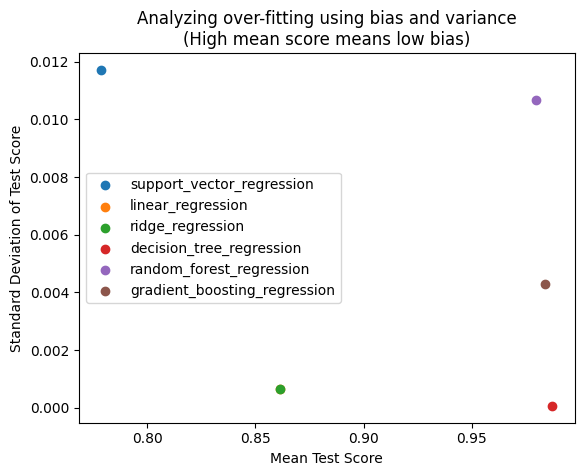

In [28]:
plt.xlabel("Mean Test Score")
plt.ylabel("Standard Deviation of Test Score")
plt.title("Analyzing over-fitting using bias and variance\n(High mean score means low bias)")
for score_d in scores:
    ser = pd.Series(score_d['split_scores'])
    plt.scatter(ser.mean(), ser.std(), label=score_d['model'])
plt.legend()

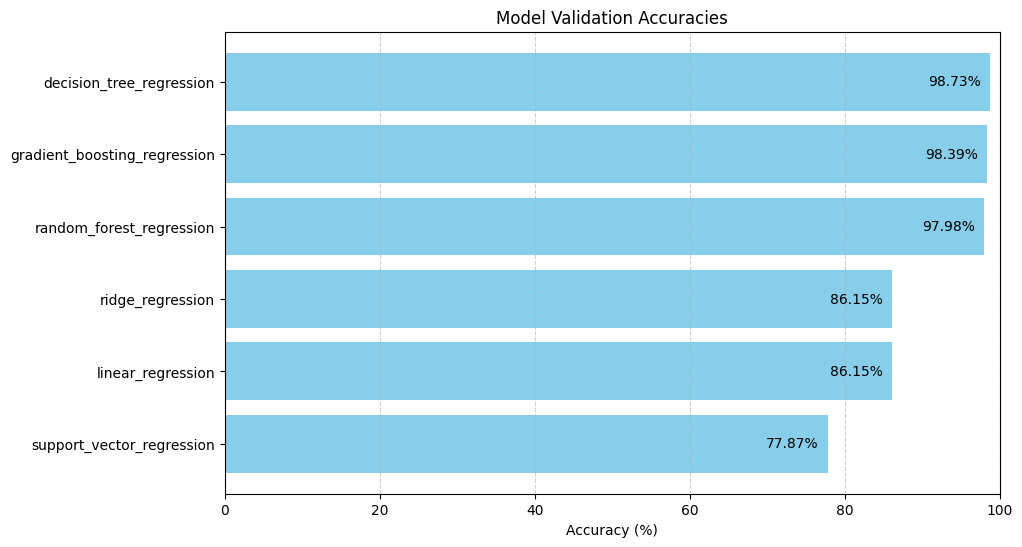

In [35]:
plt.figure(figsize=(10, 6))
bars = plt.barh(df.model, df.best_score*100, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Model Validation Accuracies')
plt.xlim(0, 100)  # Set the x-axis limits for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the accuracy values on the bars with a small offset
for bar, acc in zip(bars, df.best_score*100):
    plt.text(bar.get_width() - 8, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%', color='black', va='center')
plt.savefig("Plots/comparing_models.png")